# Notes

This notebook is for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or from a local path(see Sec. 2).


In [1]:
import os, sys
import json
import numpy as np
import mlx.core as mx
from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops
import util.misc as utils
from pprint import pprint

# Initialize and Load Pre-trained Models

In [2]:
model_config_path = "config/DINO/DINO_4scale.py" # change the path of the model config file

In [3]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'metal' 
model, criterion, postprocessors = build_model_main(args)
model = utils.load_mlx_model_with_pytorch_weights(model, args.pytorch_weights_path, args.backbone, None)
model.eval()

/Users/sachinraja/Code/DINO_DETR_MLX/util/pytorch_weights_to_mlx.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pytorch_weights_flattened = torch.load(


DINO(
  (transformer): DeformableTransformer(
    (encoder): TransformerEncoder(
      (params.encoder_layer): DeformableTransformerEncoderLayer(
        (self_attn): MSDeformAttn(
          (sampling_offsets): Linear(input_dims=256, output_dims=256, bias=True)
          (attention_weights): Linear(input_dims=256, output_dims=128, bias=True)
          (value_proj): Linear(input_dims=256, output_dims=256, bias=True)
          (output_proj): Linear(input_dims=256, output_dims=256, bias=True)
        )
        (dropout1): Dropout(p=0.0)
        (norm1): LayerNorm(256, eps=1e-05, affine=True)
        (linear1): Linear(input_dims=256, output_dims=2048, bias=True)
        (dropout2): Dropout(p=0.0)
        (linear2): Linear(input_dims=2048, output_dims=256, bias=True)
        (dropout3): Dropout(p=0.0)
        (norm2): LayerNorm(256, eps=1e-05, affine=True)
      )
      (layers.0): DeformableTransformerEncoderLayer(
        (self_attn): MSDeformAttn(
          (sampling_offsets): Linear(inp

In [4]:
# load coco names
with open('util/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

# Visualize Custom Images

In [5]:
from PIL import Image
import datasets.transforms as T

In [6]:
image = Image.open("./figs/idea.jpg").convert("RGB") # load image

In [7]:
# transform images
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)
image = mx.array(image.numpy()).transpose(1, 2, 0)

In [8]:
print(image.shape)

(1199, 800, 3)


In [9]:
# predict images
output = model(image[None])
output = postprocessors['bbox'](output, mx.array([[1.0, 1.0]]))[0]

In [10]:
pprint(output)

{'boxes': array([[0.753671, 0.638262, 1, 0.889454],
       [0.751169, 0.300905, 0.999702, 0.540427],
       [0.221359, 0.441168, 0.436835, 0.789937],
       ...,
       [0.956329, 0.590019, 1, 0.606367],
       [0.426976, 0.477636, 0.609664, 0.578968],
       [0.303678, 0.579364, 0.751804, 0.693615]], dtype=float32),
 'labels': array([62, 72, 62, ..., 76, 62, 67], dtype=uint32),
 'scores': array([0.886558, 0.740444, 0.700882, ..., 0.0225684, 0.0225316, 0.0224695], dtype=float32)}


(1199, 800, 3)


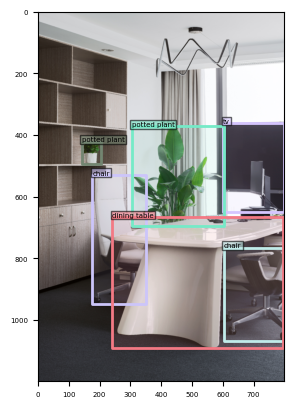

In [11]:
# visualize outputs
thershold = 0.3 # set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold
labels = np.asarray(labels)
boxes = np.asarray(boxes)
select_mask = np.asarray(select_mask)
# image = np.asarray(image)
print(image.shape)
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': mx.array([image.shape[0], image.shape[1]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=100)